# Data from Yahoo Finance

In [1]:
# Import data from yahoo finance
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(
    start='2023-04-01', 
    interval='1h'
    )

# View the data
# print(tickerDf.head())

# Only need the open, close, low, high
data = tickerDf.filter(['Open', 'Close', 'High', 'Low'])

# Print the data
print(data.head())

# Save the data to a csv file
data.to_csv(f'data/{tickerSymbol}.csv')

                                 Open       Close        High         Low
Datetime                                                                 
2023-04-03 09:30:00-04:00  286.519989  287.920013  288.269989  285.239990
2023-04-03 10:30:00-04:00  287.915009  285.820007  288.049988  285.429993
2023-04-03 11:30:00-04:00  285.799988  284.670013  285.984985  284.605011
2023-04-03 12:30:00-04:00  284.660004  284.170013  285.048798  283.950012
2023-04-03 13:30:00-04:00  284.149994  284.880005  285.190002  284.089996


# Training & Prediction

In [2]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Load the dataset
data = pd.read_csv(f'data/{tickerSymbol}.csv')

In [4]:
data.columns = [i.lower() for i in data.columns]
data.columns

Index(['datetime', 'open', 'close', 'high', 'low'], dtype='object')

In [5]:
data.head()

,datetime,open,close,high,low
0,2023-04-03 09:30:00-04:00,286.519989,287.920013,288.269989,285.239990
1,2023-04-03 10:30:00-04:00,287.915009,285.820007,288.049988,285.429993
2,2023-04-03 11:30:00-04:00,285.799988,284.670013,285.984985,284.605011
3,2023-04-03 12:30:00-04:00,284.660004,284.170013,285.048798,283.950012
4,2023-04-03 13:30:00-04:00,284.149994,284.880005,285.190002,284.089996


In [6]:
data.isna().any()

datetime    False
open        False
close       False
high        False
low         False
dtype: bool

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  3102 non-null   object 
 1   open      3102 non-null   float64
 2   close     3102 non-null   float64
 3   high      3102 non-null   float64
 4   low       3102 non-null   float64
dtypes: float64(4), object(1)
memory usage: 121.3+ KB


In [8]:
data.shape

(3102, 5)

In [9]:
data.duplicated().sum()

0

In [10]:
data['date'] = pd.to_datetime(data['datetime'])
data.set_index('date',inplace=True)
data.drop('datetime',axis=1,inplace=True)

C:\Users\iamka\AppData\Local\Temp\ipykernel_10504\4276217009.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['datetime'])


In [11]:
data.head()

,open,close,high,low
date,,,,
2023-04-03 09:30:00-04:00,286.519989,287.920013,288.269989,285.239990
2023-04-03 10:30:00-04:00,287.915009,285.820007,288.049988,285.429993
2023-04-03 11:30:00-04:00,285.799988,284.670013,285.984985,284.605011
2023-04-03 12:30:00-04:00,284.660004,284.170013,285.048798,283.950012
2023-04-03 13:30:00-04:00,284.149994,284.880005,285.190002,284.089996


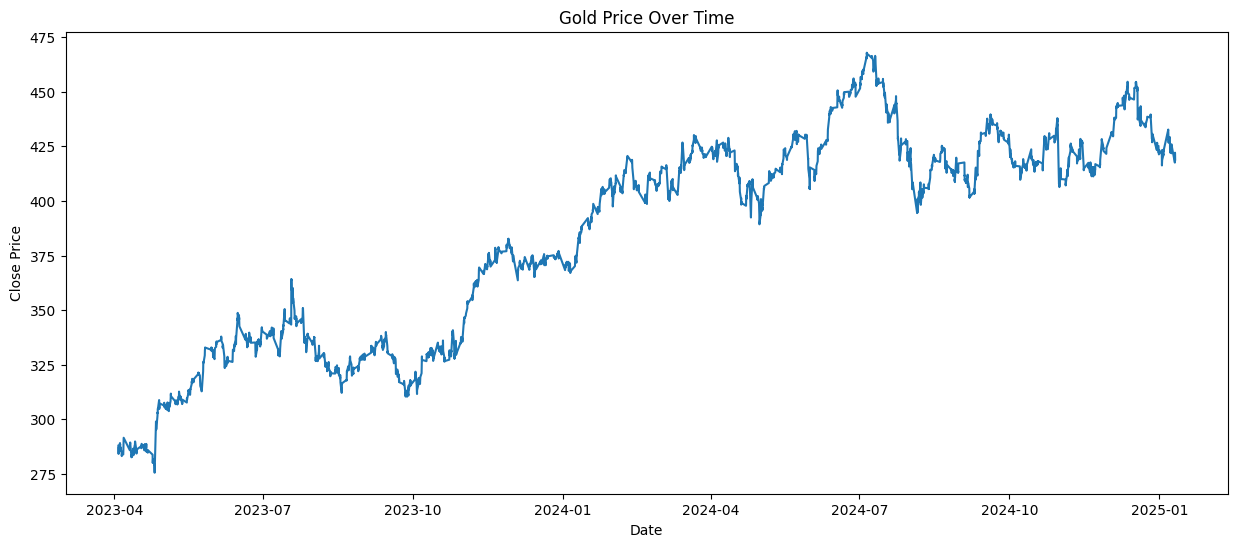

In [12]:
# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(data['close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Gold Price Over Time')
plt.show()

In [13]:
# Function to generate feature technical indicators
def get_technical_indicators(dataset):

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['close'].rolling(window = 21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = (dataset['close']/100)-1
    
    return dataset

technical_data = data.copy()
technical_data = get_technical_indicators(technical_data)

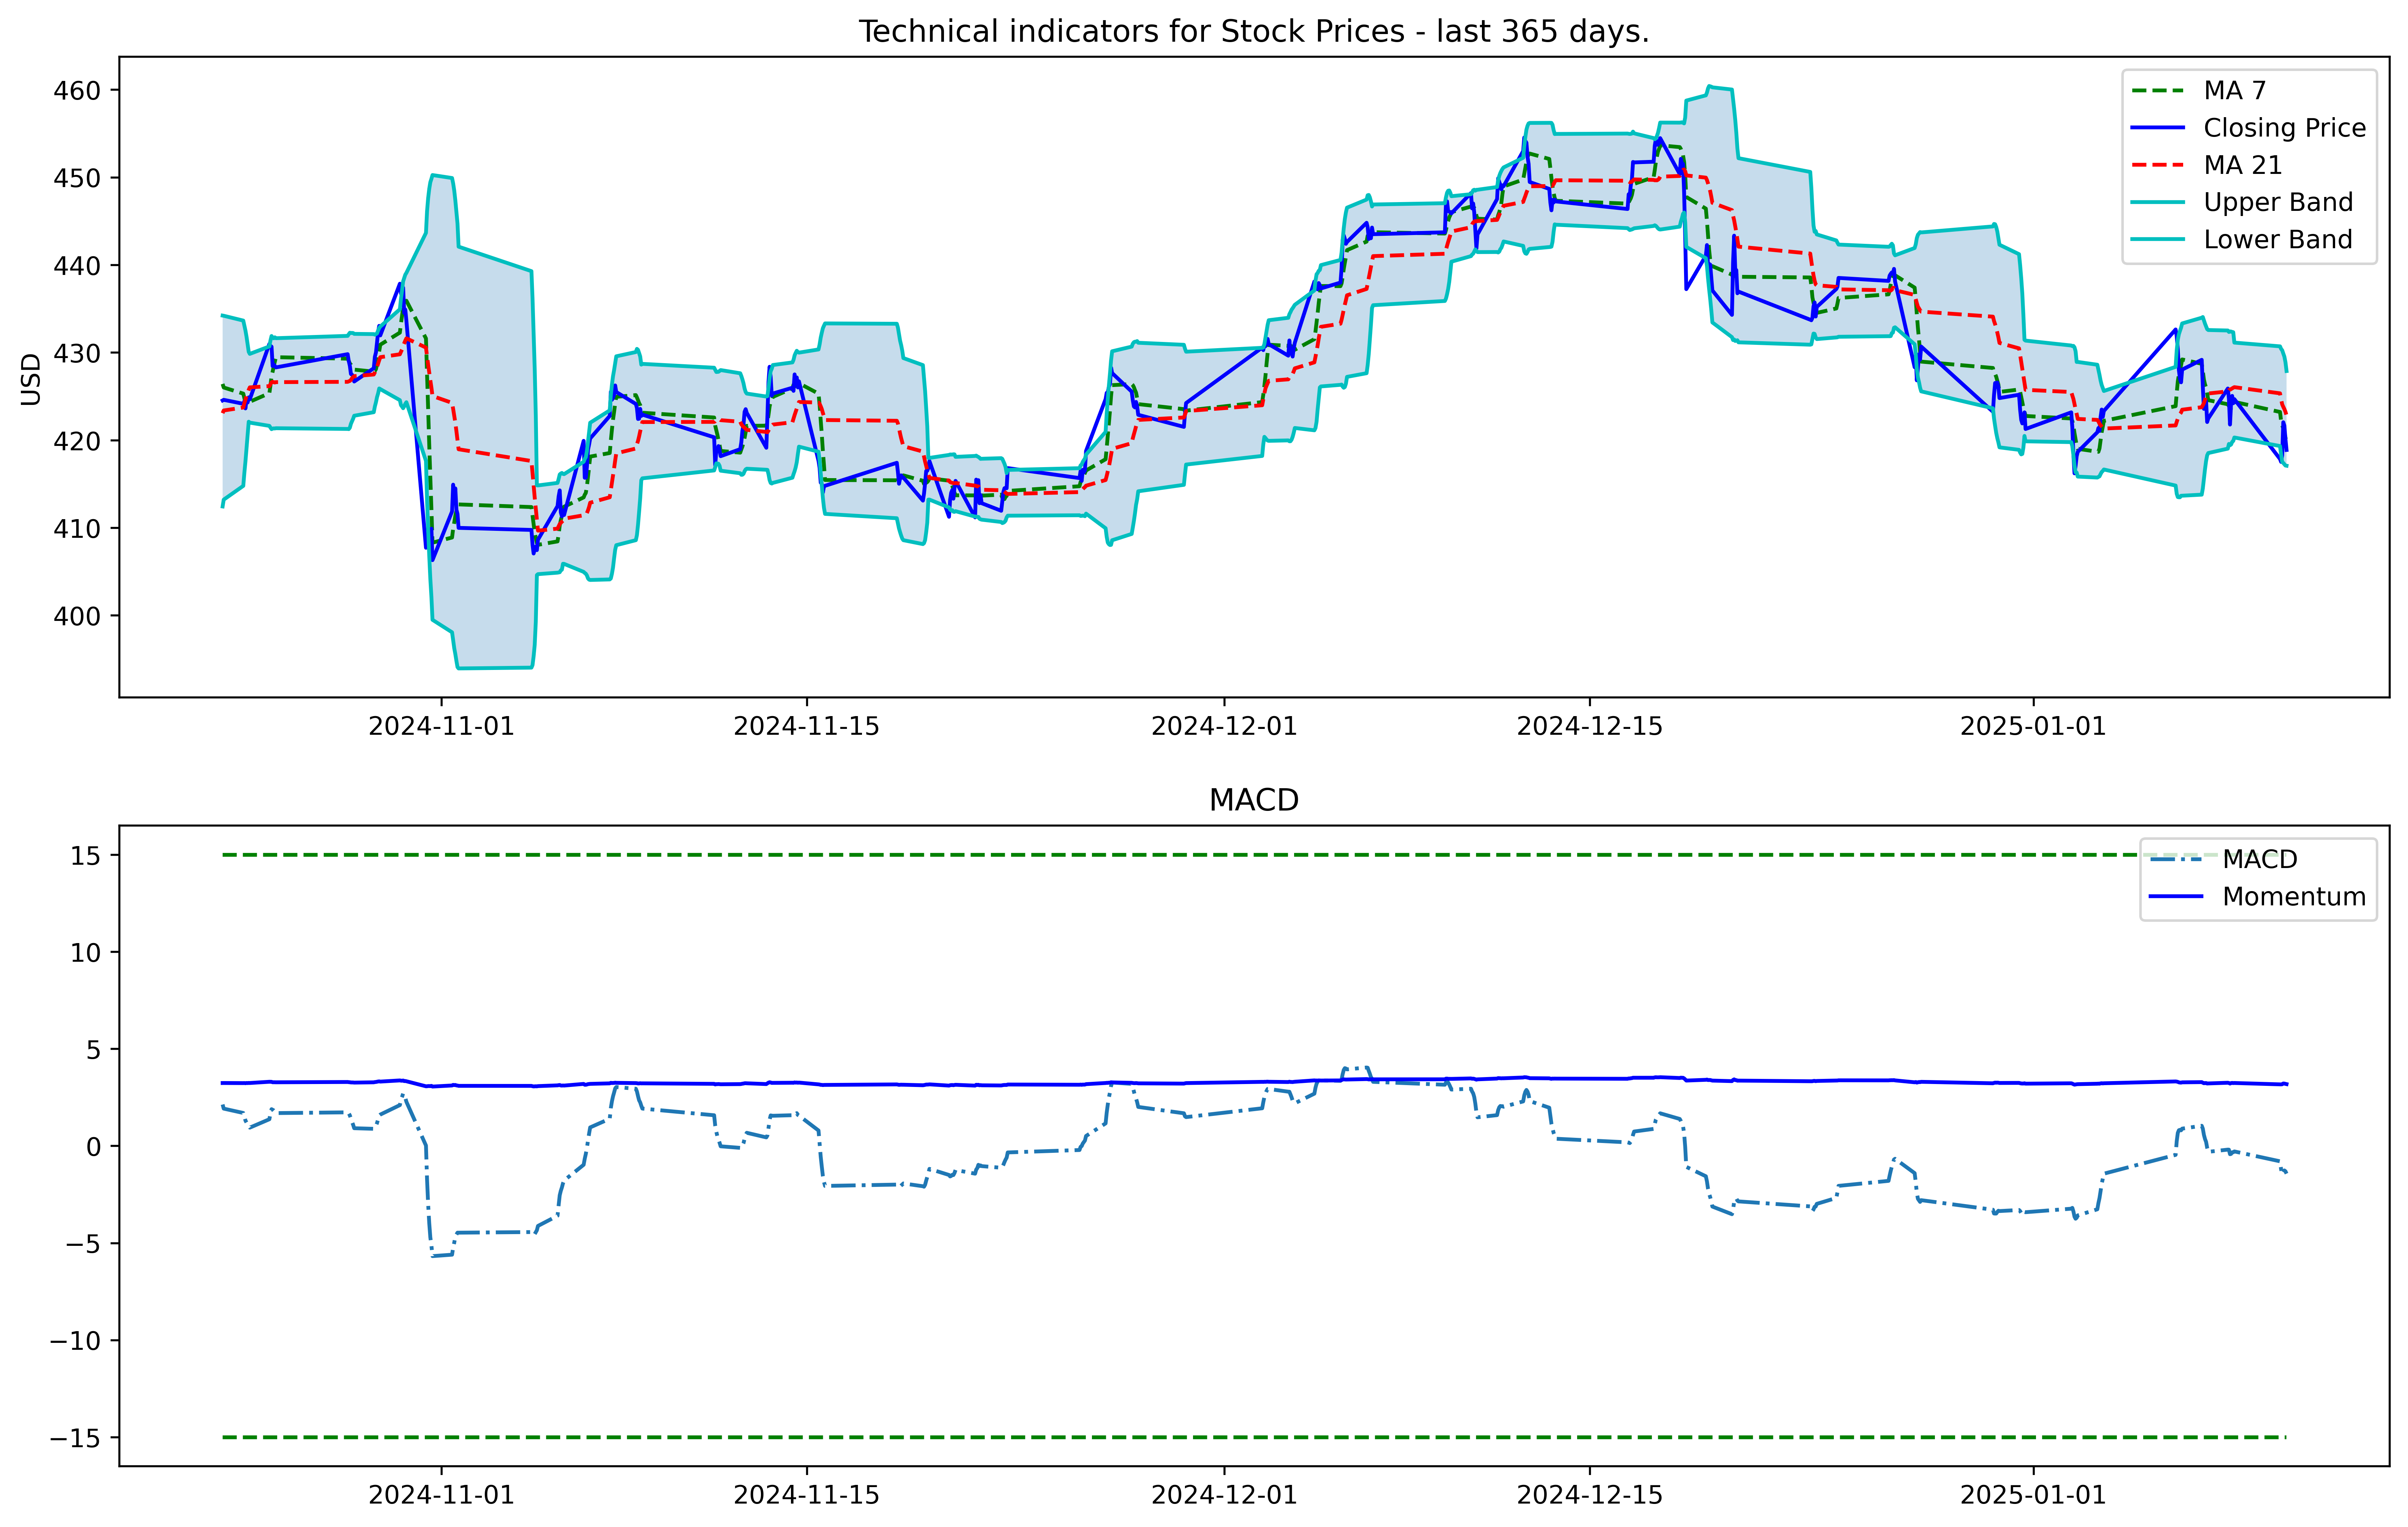

In [14]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=500)
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.25)
    plt.title('Technical indicators for Stock Prices - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')
    plt.hlines(15, dataset.index.min(), dataset.index.max(), colors='g', linestyles='--')
    plt.hlines(-15, dataset.index.min(), dataset.index.max(), colors='g', linestyles='--')

    plt.legend()
    plt.show()

plot_technical_indicators(technical_data, 365)

In [15]:
data.index.min()

Timestamp('2023-04-03 09:30:00-0400', tz='UTC-04:00')

In [16]:
data.index.max()

Timestamp('2025-01-10 15:30:00-0500', tz='UTC-05:00')

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sp2 import *

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

X, y = create_sequences(scaled_data, seq_length=90)
print(X.shape, y.shape)

# Split into training and validation datasets
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([3012, 90, 4]) torch.Size([3012, 4])


cuda
Epoch [1/20], Train Loss: 0.0434, Val Loss: 0.0006
Epoch [2/20], Train Loss: 0.0050, Val Loss: 0.0009
Epoch [3/20], Train Loss: 0.0042, Val Loss: 0.0004
Epoch [4/20], Train Loss: 0.0041, Val Loss: 0.0010
Epoch [5/20], Train Loss: 0.0030, Val Loss: 0.0045
Epoch [6/20], Train Loss: 0.0029, Val Loss: 0.0005
Epoch [7/20], Train Loss: 0.0025, Val Loss: 0.0019
Epoch [8/20], Train Loss: 0.0026, Val Loss: 0.0004
Epoch [9/20], Train Loss: 0.0023, Val Loss: 0.0003
Epoch [10/20], Train Loss: 0.0021, Val Loss: 0.0006
Epoch [11/20], Train Loss: 0.0020, Val Loss: 0.0003
Epoch [12/20], Train Loss: 0.0019, Val Loss: 0.0003
Epoch [13/20], Train Loss: 0.0017, Val Loss: 0.0007
Epoch [14/20], Train Loss: 0.0019, Val Loss: 0.0007
Epoch [15/20], Train Loss: 0.0017, Val Loss: 0.0005
Epoch [16/20], Train Loss: 0.0017, Val Loss: 0.0004
Epoch [17/20], Train Loss: 0.0016, Val Loss: 0.0005
Epoch [18/20], Train Loss: 0.0016, Val Loss: 0.0006
Epoch [19/20], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [20/20], T

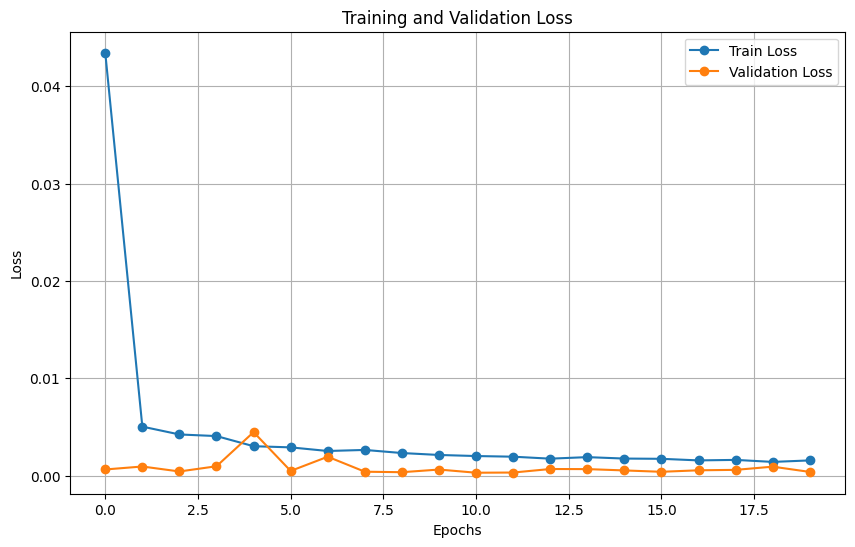

In [18]:
# Model initialization
input_size = len(data.columns)
gru_hidden_size = 100
lstm_hidden_size1 = 100
lstm_hidden_size2 = 50
dropout_rate = 0.2

model = HybridBiGRU_LSTM(input_size, gru_hidden_size, lstm_hidden_size1, lstm_hidden_size2, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
trained_model, loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device=device)

# save model
torch.save(trained_model.state_dict(), f'models/{tickerSymbol}.pt')

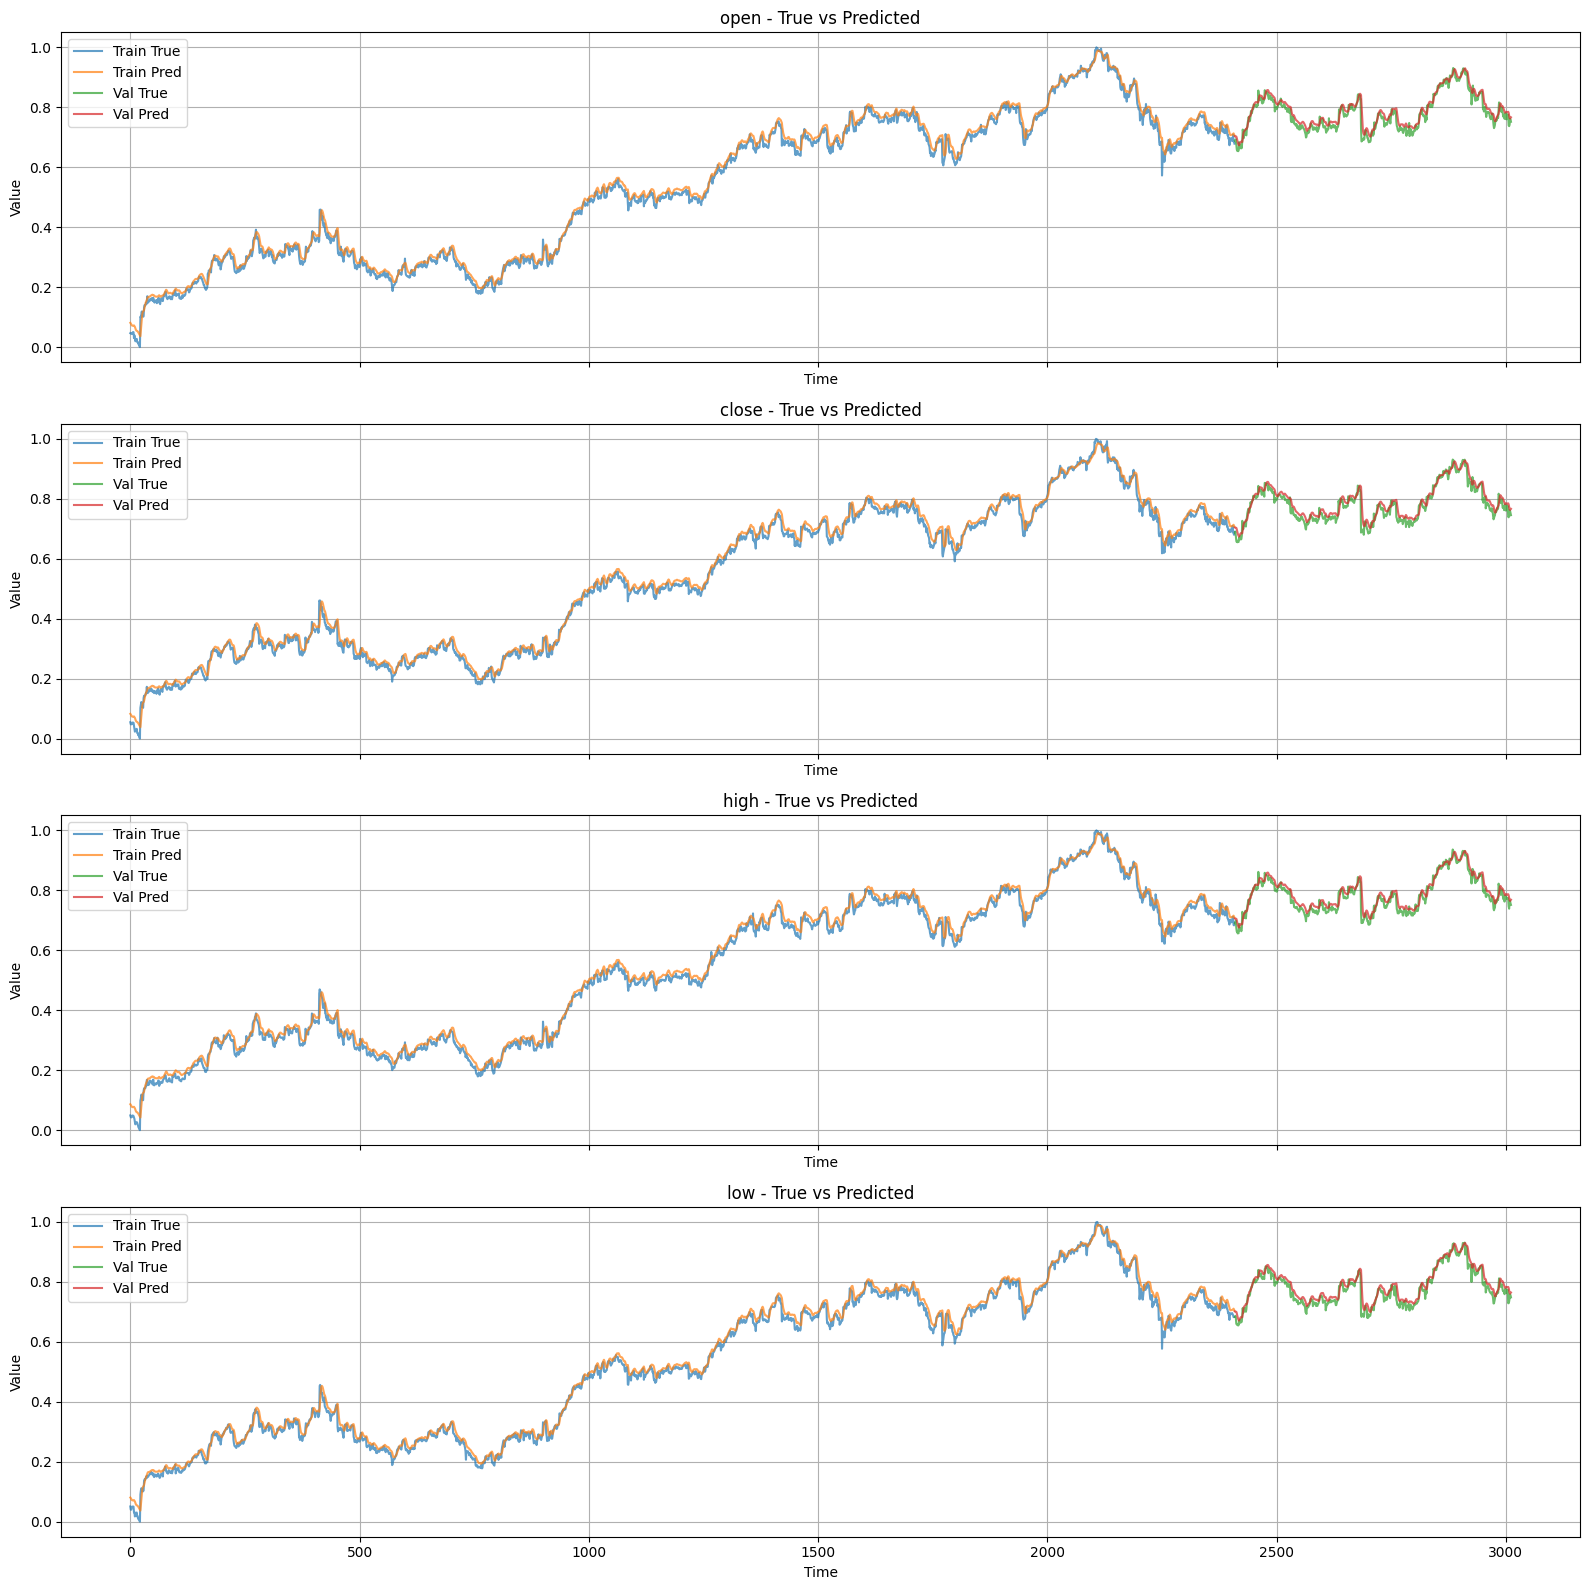

In [19]:
# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train.to(device)).cpu().numpy()
    y_pred_val = model(X_val.to(device)).cpu().numpy()

plot_predictions(
    y_train.numpy(), 
    y_pred_train, 
    y_val.numpy(), 
    y_pred_val, 
    feature_names=['open', 'close', 'high', 'low']
)